In [1]:

import numpy as np
from numpy import vectorize
from scipy import interpolate, integrate
from scipy import special
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import timeit

def concentration(Mvir, cosmo_h):
    '''Maccio 07 - Eq. 8. I also found that it is only within 1e9 < M < 5e13.
       What is this Delta_vir=98 in page 57
    '''
    Mvir = Mvir / cosmo_h
    conc = 10**(1.02 - 0.109 * (np.log10(Mvir) - 12.))
    return conc

def f_Rfrac(Rfrac, rho_s, Rs, rho_critical, frac):
    return (frac * rho_critical * Rfrac**3. / 3.) - (rho_s * Rs**3) * (np.log((Rs + Rfrac) / Rs) - Rfrac / (Rs + Rfrac))

def df_Rfrac(Rfrac, rho_s, Rs, rho_critical, frac):
    return (frac * rho_critical * Rfrac**2.) - (rho_s * Rs**3) * (Rfrac / (Rs + Rfrac)**2.)

def MvirToMRfrac(Mvir, BryanDelta, rho_critical, cosmo_h):
    '''Convert Mvir in solar mass to Rvir in Mpc, M200 in solar mass 
       R200 in Mpc
    '''
    conc = concentration(Mvir, cosmo_h)
    #print Mvir, conc
    Rvir = (Mvir / ((4 * np.pi / 3.) * BryanDelta * rho_critical))**(1/3.) #(Msun / Msun Mpc^(-3))1/3. -> Mpc    
    rho_s = rho_critical * (BryanDelta / 3.) * conc**3. / (np.log(1 + conc) - conc / (1 + conc)) #Msun / Mpc^3  
    Rs = Rvir / conc

    tolerance = 1e-6
    frac = 200.0

    # Using Newton - Raphson method. x1 = x0 - f(x0) / f'(x0) where x0 is
    # the initial guess, f and f' are the function and derivative

    # Intial guess is Rvir / 2. 
    x0 = Rvir / 2.0
    tol = Rvir * tolerance #tolerance
    x1 = tol * 10**6
    #print 1, x0, x1
    while abs(x0 - x1) > tol:
        #print abs(x0 - x1), tol
        x0 = x1 * 1.0
        x1 = x0 - f_Rfrac(x0, rho_s, Rs, rho_critical, frac) / df_Rfrac(x0, rho_s, Rs, rho_critical, frac)
        #print x0, x1
    Rfrac = x1
    Mfrac = (4. / 3.) * np.pi * Rfrac**3 * frac * rho_critical
    #print Mvir, Mfrac, Rvir, Rfrac
    return Mfrac, Rfrac 

def battaglia_profile(r, Mvir, z, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h):
    '''
    Using Battaglia et al (2012). 
    Eq. 10. M200 in solar mass and R200 in Mpc
    Retrun: 
        Pressure profile in keV/cm^3 at radius r
    '''
    M200, R200 = MvirToMRfrac(Mvir, BryanDelta, rho_critical, cosmo_h)
    #It seems R200 is in the physical distance, i.e. proper distance
    #Need to multiplied by (1+z) to get the comoving unit as I am giving r in
    #comoving unit.
    R200 *= (1. + z) #Comoving radius 
    x = r / R200
    #print Mvir, M200, R200
    msolar = 1.9889e30 #kg
    mpc2cm = 3.0856e24 #cm 
    G = 4.3e-9 #Mpc Mo^-1 (km/s)^2 
    alpha = 1.0
    gamma = -0.3
    P200 = 200. * rho_critical * omega_b0 * G * M200 / omega_m0 / 2. / (R200 / (1. + z)) #Msun km^2 / Mpc^3 / s^2

    P0 = 18.1 * ((M200 / 1e14)**0.154 * (1. + z)**-0.758)
    xc = 0.497 * ((M200 / 1e14)**-0.00865 * (1. + z)**0.731)
    beta = 4.35 * ((M200 / 1e14)**0.0393 * (1. + z)**0.415) 
    #print Mvir,z,R200,P200,P0, xc, beta
    #print (P200*msolar * 6.24e18 * 1e3 / mpc2cm**3), P0, xc, beta
    pth = P200 * P0 * (x / xc)**gamma * (1. + (x/xc))**(-1. * beta) #(km/s)^2 M_sun / Mpc^3

    #Joule = kg m^2 / s^2, Joule = 6.24e18 eV = 6.24e15 keV
    pth *= (msolar * 6.24e15 * 1e6 / mpc2cm**3) #keV/cm^3. 1e6 implies that I have converted km to m
    p_e = pth * 0.518 #For Y=0.24, Vikram, Lidz & Jain
    return p_e

def project_profile(radius, profile) :
        if np.nonzero(profile <= 0)[0].size > 0 : raise Exception("negative profile")
        max_radius = 15
        profile_spline = interp1d(radius, profile, bounds_error=False, fill_value="extrapolate")
        dr = 0.001
        rmin = 0.
        space = int(1 + (max_radius - rmin) / dr)
        sqxi = np.linspace(rmin, max_radius, space)**2.
        profile_projected = []
        for r in radius:
            R = np.sqrt(r**2. + sqxi)
            R = R[R < max_radius]
            profile_projected.append(profile_spline(R).sum()*dr)
        profile_projected = np.array(profile_projected)
        new_radius = radius 
        return new_radius, profile_projected

def make_proj_image(radius, profile) :
        maxRadius = 15
        pixel_scale = 0.15
        image_size = np.round(maxRadius*2/pixel_scale)
        #profile_spline = interp1d(radius, profile, bounds_error=False, fill_value="extrapolate")
        profile_spline = interp1d(radius, profile, bounds_error=False)
        image = np.zeros((np.int_((image_size/2)+1),np.int_(image_size/2)+1))
        rcen, ccen = 0,0
        for r in range(0,np.shape(image)[0]) :
            for c in range(0,np.shape(image)[1]) :
                radius = np.sqrt((r-rcen)**2+(c-ccen)**2) * pixel_scale
                if radius == 0. : radius = 0.1 * pixel_scale
                image[r][c] = profile_spline(radius)
        return image

def make_proj_image_new(radius, profile,maxRadius=1.5,pixel_scale=0.015,extrapolate=False):
        # You use this quantity as matrix size.
        # I doubt that system dependent np.int32 or np.int64 will have different behaviour
        image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

        if extrapolate:
            profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
        else:
            profile_spline = interp1d(radius, profile, bounds_error=False)

        # x and y indices matrices
        x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
        # matrix of radii with center in x=image_size//2,y=image_size//2
        r = np.sqrt((x-image_size//2)**2+(y-image_size//2)**2)*pixel_scale
        # numpy and scipy usually maps functions over matrices
        image = profile_spline(r)
        return image
    
def make_proj_image_new_2(radius, profile,maxRadius=0.15,pixel_scale=0.0015,extrapolate=False):
        # You use this quantity as matrix size.
        # I doubt that system dependent np.int32 or np.int64 will have different behaviour
        image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

        if extrapolate:
            profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
        else:
            profile_spline = interp1d(radius, profile, bounds_error=False)

        # x and y indices matrices
        x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
        # matrix of radii with center in x=image_size//2,y=image_size//2
        r = np.sqrt((x-image_size//2)**2+(y-image_size//2)**2)*pixel_scale
        # numpy and scipy usually maps functions over matrices
        image = profile_spline(r)
        return image
    
def f_sz(f, T_CMB):
    planck_const = 6.626e-34         #m^2 kg/s
    boltzman_const = 1.38e-23
    x = planck_const * f / boltzman_const / T_CMB
    return x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4

In [2]:
#Variable inputs
Mass = 1e13
redshift = 0.1

a = 1.0/(1.0 + redshift)
E0 = 0.73 + 0.27/(a*a*a) + 0./(a*a)
x = 0.27 - 1
BryanDelta = 18 * np.pi * np.pi + 82. * x - 39. * x * x
rho_crit = 1.879/(1.989)*3.086**3*1e10 * E0
rho_critical = rho_crit * 0.7 * 0.7
omega_b0 = 0.044
omega_m0 = 0.27
cosmo_h = 0.7
radius = np.linspace(0.1, 2, 1000)

In [3]:
battaglia_pro = np.array([battaglia_profile(r, Mass, redshift, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h) for r in np.linspace(0.1, 2, 1000)])
constant = 6.65246e-29 / (9.11e-31) / ((3.0e8) ** 2)         #s^2/kg
Mpc_to_m = 3.09e22
kevcm_to_im = 1.6e-16 * 1e6
new_battaglia = battaglia_pro * kevcm_to_im
y_pro = new_battaglia * constant * Mpc_to_m

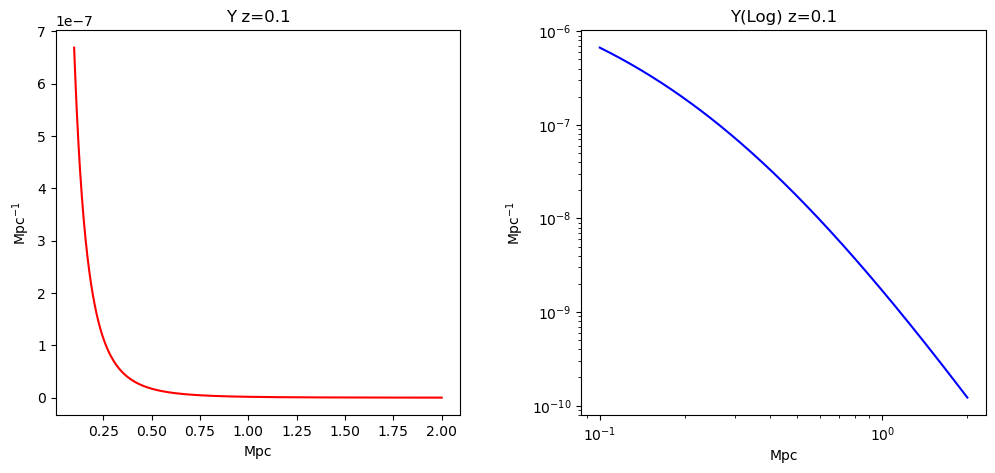

In [4]:
fig,ax = plt.subplots(1,2,figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
ax[0].plot(radius, y_pro, color = "red", label = "non-log")
ax[0].set_xlabel("Mpc")
ax[0].set_ylabel(r'Mpc$^{-1}$')
ax[0].title.set_text("Y z="+str(redshift))
ax[1].loglog(radius, y_pro, color = "blue", label = "log")
ax[1].set_xlabel("Mpc")
ax[1].set_ylabel(r'Mpc$^{-1}$')
ax[1].title.set_text("Y(Log) z="+str(redshift))
plt.show()

Text(0.5, 0, '0.1Mpc')

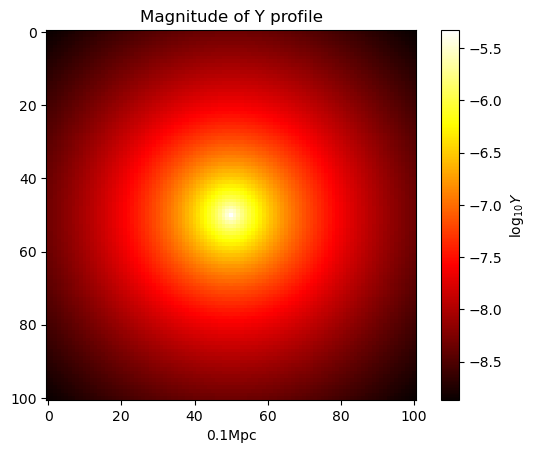

In [5]:
log_image = make_proj_image_new(radius,np.log10(y_pro),extrapolate=True)
plt.imshow(log_image, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\log_{10}Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('0.1Mpc')

Text(0.5, 0, '0.01Mpc')

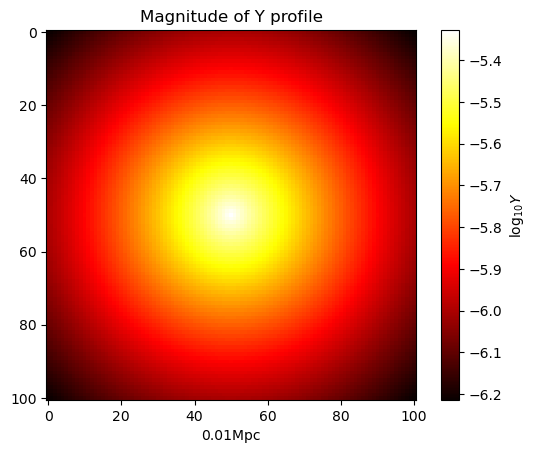

In [6]:
log_image_2 = make_proj_image_new_2(radius,np.log10(y_pro),extrapolate=True)
plt.imshow(log_image_2, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\log_{10}Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('0.01Mpc')

The y-profile is now adjusted to the right scale. Next step include modifying make_proj_image:
    1. place the galaxy in the middle
    2. If around 1 Mpc, no need to use log scale
Other:
    1. Change the cmap parameter
    2. Interpolation + Extrapolation (perhaps inside make_proj_image)
    3. Add Apeture ect. as Eve requested

## Converting comoving distance to angular scale

In [7]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)
Kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(redshift).value
Mpc_per_arcmin = Kpc_per_arcmin/1000
arcmin = radius / Mpc_per_arcmin

## Mapping from Compton-Y to CMB

Text(0.5, 0, '0.01Mpc')

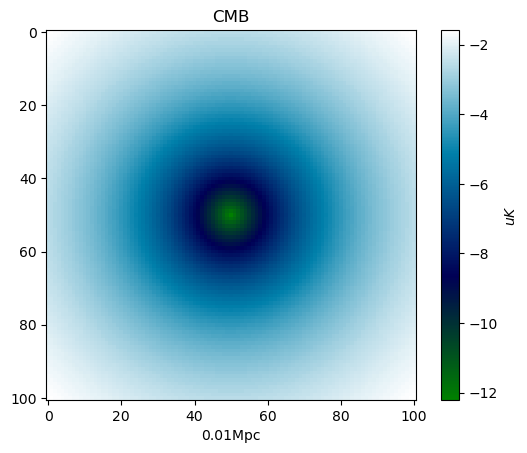

In [8]:
f = 1.5e11               #Hz
t_cmb = 2.725            #K
fsz = f_sz(f, t_cmb)
new_img = 10 ** log_image_2
cmb_img = new_img * fsz * t_cmb * 1e6
plt.imshow(cmb_img, cmap='ocean')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$uK$')
plt.title('CMB')
plt.xlabel('0.01Mpc')

## White Noise

Text(0.5, 0, '0.01Mpc')

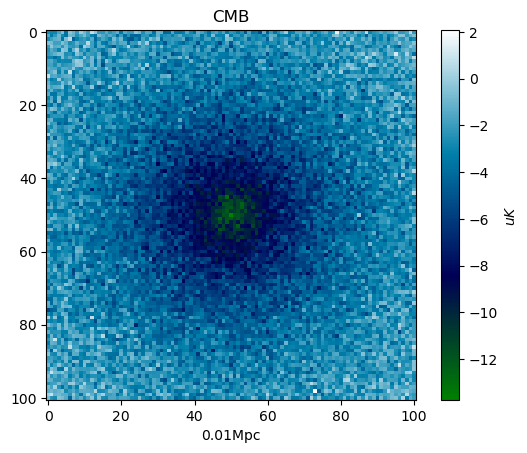

In [9]:
noise_level = 1                      #Can change level
noise = np.random.normal(0, 1, (101,101)) * noise_level
CMB_noise = cmb_img + noise
plt.imshow(CMB_noise, cmap='ocean')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$uK$')
plt.title('CMB')
plt.xlabel('0.01Mpc')

## Mapping from CMB to Compton-Y

Text(0.5, 0, '0.01Mpc')

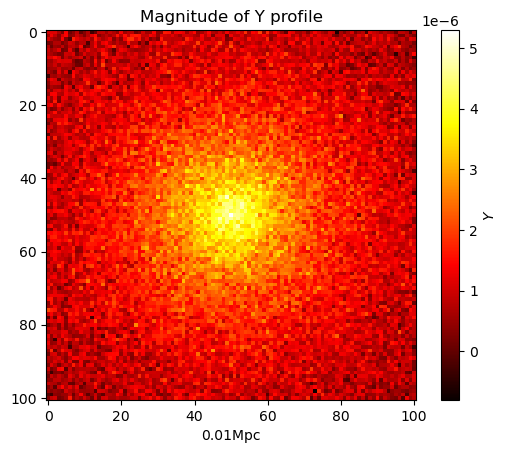

In [10]:
y_noise = CMB_noise / fsz / t_cmb / 1e6
plt.imshow(y_noise, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('0.01Mpc')